In [1]:
import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as mp
import matplotlib.colors as mc
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import matplotlib
import scipy.ndimage
import datetime

import itertools
import random
import numpy.random
import scipy.stats
import os

mp.rcParams.update({'mathtext.default': 'regular'})

from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1

degree_sign = u'\u00B0'
% matplotlib inline

In [2]:
model_names = numpy.array(( \
'ACCESS1-0', \
'ACCESS1-3', \
'bcc-csm1-1-m', \
'bcc-csm1-1', \
'BNU-ESM', \
'CanESM2', \
'CCSM4', \
'CESM1-BGC', \
'CESM1-CAM5', \
'CMCC-CESM', \
'CMCC-CM', \
'CMCC-CMS', \
'CNRM-CM5', \
'CSIRO-Mk3-6-0', \
'EC-EARTH', \
'FGOALS-g2', \
'GFDL-CM3', \
'GFDL-ESM2G', \
'GFDL-ESM2M', \
'GISS-E2-H', \
'GISS-E2-R', \
'HadGEM2-AO', \
'HadGEM2-CC', \
'HadGEM2-ES', \
'inmcm4', \
'IPSL-CM5A-LR', \
'IPSL-CM5A-MR', \
'IPSL-CM5B-LR', \
'MIROC5', \
'MIROC-ESM-CHEM', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MPI-ESM-MR', \
'MRI-CGCM3', \
'NorESM1-ME', \
'NorESM1-M' ))
nmods = len(model_names)

In [3]:
pr_lat_lo, pr_lat_hi, pr_lon_lo, pr_lon_hi = 30., 45., 232.5, 248; region = 'CA'
ts_lat_lo, ts_lat_hi, ts_lon_lo, ts_lon_hi = -30., 10., 155., 270.; region = 'tropacific'
ua_lat_lo, ua_lat_hi, ua_lon_lo, ua_lon_hi = 20., 50., 170., 250.; region = 'midlatpacific'

season='djf'; SEASON='DJF'

In [5]:
# OPEN TS DATASET
ncfile = Dataset('../../../DATA/cmip5_data/ts/djf/NorESM1-M_ts_1980-10_climatology_djf.nc', 'r', format='NETCDF4')

ts_data_orig = ncfile.variables['ts'][:]
ts_lat = ncfile.variables['lat'][:]
ts_lon = ncfile.variables['lon'][:]

# pull out lat/lon indices
ts_lat_inds = numpy.where((ts_lat>=ts_lat_lo) & (ts_lat<=ts_lat_hi))[0]
ts_lon_inds = numpy.where((ts_lon>=ts_lon_lo) & (ts_lon<=ts_lon_hi))[0]
ts_regional_lat_vals = ts_lat[ts_lat_inds[0]:(ts_lat_inds[-1]+1)]
ts_regional_lon_vals = ts_lon[ts_lon_inds[0]:(ts_lon_inds[-1]+1)]    

ts_data = ts_data_orig[ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
ts_regional_nlat, ts_regional_nlon = ts_data.shape
global_nlat, global_nlon = ts_data_orig.shape[0:2]
global_lat_vals = ts_lat[:]
global_lon_vals = ts_lon[:]

In [6]:
# OPEN TS OBSERVATIONS
ncfile = Dataset('../../../DATA/obs_data/ERSSTv4/obs_ERSSTv4_72x144_SST_1980-2010_climatology_'+season+'.nc', 'r', format='NETCDF4')
obs_field_ts = ncfile.variables['sst'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]

# OPEN PR OBSERVATIONS
ncfile = Dataset('../../../DATA/obs_data/pr_gpcp/obs_GPCP_72x144_PRECT_1980-2010_climatology_'+season+'.nc', 'r', format='NETCDF4')
pr_lat = ncfile.variables['lat'][:]
pr_lon = ncfile.variables['lon'][:]
pr_lat_inds = numpy.where((pr_lat>=pr_lat_lo) & (pr_lat<=pr_lat_hi))[0]
pr_lon_inds = numpy.where((pr_lon>=pr_lon_lo) & (pr_lon<=pr_lon_hi))[0]
obs_field_pr = ncfile.variables['PRECT'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
pr_regional_nlat, pr_regional_nlon = obs_field_pr.shape

pr_regional_lat_vals = pr_lat[pr_lat_inds[0]:(pr_lat_inds[-1]+1)]
pr_regional_lon_vals = pr_lon[pr_lon_inds[0]:(pr_lon_inds[-1]+1)] 

# OPEN UA OBSERVATIONS
ncfile = Dataset('../../../DATA/obs_data/u200_MERRA/obs_MERRA_2.5x2.5_u200_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
ua_lat = ncfile.variables['lat'][:]
ua_lon = ncfile.variables['lon'][:]
ua_lat_inds = numpy.where((ua_lat>=ua_lat_lo) & (ua_lat<=ua_lat_hi))[0]
ua_lon_inds = numpy.where((ua_lon>=ua_lon_lo) & (ua_lon<=ua_lon_hi))[0]
obs_field_ua = ncfile.variables['u200'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
ua_regional_nlat, ua_regional_nlon = obs_field_ua.shape

ua_regional_lat_vals = ua_lat[ua_lat_inds[0]:(ua_lat_inds[-1]+1)]
ua_regional_lon_vals = ua_lon[ua_lon_inds[0]:(ua_lon_inds[-1]+1)] 

In [7]:
# set up data
model_data_hist_pr = numpy.zeros((len(model_names), pr_regional_nlat, pr_regional_nlon))
model_data_eoc_pr = numpy.zeros((len(model_names), pr_regional_nlat, pr_regional_nlon))
model_data_hist_pr_LENS = numpy.zeros((40, pr_regional_nlat, pr_regional_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../../DATA/cmip5_data/pr/'+season+'/'+modelname+'_pr_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_pr[i,:,:] = ncfile.variables['pr'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../../DATA/cmip5_data/pr/'+season+'/'+modelname+'_pr_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_pr[i,:,:] = ncfile.variables['pr'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    ncfile.close()

LENS_names = ['{:02d}'.format(i) for i in range(1,36)] + ['{:03d}'.format(i) for i in range(101,106)]
for i in range(len(LENS_names)): # 40
    member_name = LENS_names[i]
    # get convective precipitation
    ncfile = Dataset('../../../DATA/lens_data/PRECC/'+season+'/'+member_name + '_PRECC_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    precc_temp = ncfile.variables['PRECC'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    # get large-scale precipitation
    ncfile = Dataset('../../../DATA/lens_data/PRECL/'+season+'/'+member_name + '_PRECL_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    precl_temp = ncfile.variables['PRECL'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    # add together
    model_data_hist_pr_LENS[i,:,:] = precc_temp + precl_temp

In [8]:
# IMPORT TS DATA
model_data_hist_ts = numpy.zeros((len(model_names), ts_regional_nlat, ts_regional_nlon))
model_data_eoc_ts = numpy.zeros((len(model_names), ts_regional_nlat, ts_regional_nlon))
model_data_hist_ts_LENS = numpy.zeros((40, ts_regional_nlat, ts_regional_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../../DATA/cmip5_data/ts/'+season+'/'+modelname+'_ts_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_ts[i,:,:] = ncfile.variables['ts'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../../DATA/cmip5_data/ts/'+season+'/'+modelname+'_ts_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_ts[i,:,:] = ncfile.variables['ts'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
    ncfile.close()

LENS_names = ['{:02d}'.format(i) for i in range(1,36)] + ['{:03d}'.format(i) for i in range(101,106)]
for i in range(len(LENS_names)): # 40
    member_name = LENS_names[i]
    # get convective precipitation
    ncfile = Dataset('../../../DATA/lens_data/TS/'+season+'/'+member_name + '_TS_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    model_data_hist_ts_LENS[i,:,:] = ncfile.variables['TS'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]    

In [9]:
# IMPORT UA200 DATA
model_data_hist_ua = numpy.zeros((len(model_names), ua_regional_nlat, ua_regional_nlon))
model_data_eoc_ua = numpy.zeros((len(model_names), ua_regional_nlat, ua_regional_nlon))
model_data_hist_ua_LENS = numpy.zeros((40, ua_regional_nlat, ua_regional_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../../DATA/cmip5_data/ua200/'+season+'/'+modelname+'_ua200_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_ua[i,:,:] = ncfile.variables['ua'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../../DATA/cmip5_data/ua200/'+season+'/'+modelname+'_ua200_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_ua[i,:,:] = ncfile.variables['ua'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
    ncfile.close()

LENS_names = ['{:02d}'.format(i) for i in range(1,36)] + ['{:03d}'.format(i) for i in range(101,106)]
for i in range(len(LENS_names)): # 40
    member_name = LENS_names[i]
    # get convective precipitation
    ncfile = Dataset('../../../DATA/lens_data/U200/'+season+'/'+member_name + '_U_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    model_data_hist_ua_LENS[i,:,:] = ncfile.variables['U'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]    

In [10]:
ncal_latlon = numpy.load('../../../DATA/ncal_latlon_array.npy')
ccal_latlon = numpy.load('../../../DATA/ccal_latlon_array.npy')
scal_latlon = numpy.load('../../../DATA/scal_latlon_array.npy')

In [12]:
# precip indices
pr_indices_lon_ncal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, ncal_latlon[i,0]))[0][0] for i in range(ncal_latlon.shape[0]) ]
pr_indices_lat_ncal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, ncal_latlon[i,1]))[0][0] for i in range(ncal_latlon.shape[0]) ]

pr_indices_lon_ccal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, ccal_latlon[i,0]))[0][0] for i in range(ccal_latlon.shape[0]) ]
pr_indices_lat_ccal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, ccal_latlon[i,1]))[0][0] for i in range(ccal_latlon.shape[0]) ]

pr_indices_lon_scal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, scal_latlon[i,0]))[0][0] for i in range(scal_latlon.shape[0]) ]
pr_indices_lat_scal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, scal_latlon[i,1]))[0][0] for i in range(scal_latlon.shape[0]) ]

# take all data and ravel

In [15]:
# NOW TAKE ALL PR DATA AND RAVEL IT
# CALCULATE ENSEMBLE MEAN FOR EOC CONVERGENCE
model_field_mmem_pr = numpy.mean(model_data_eoc_pr, axis=0)
model_field_mmem_ts = numpy.mean(model_data_eoc_ts, axis=0)
model_field_mmem_ua = numpy.mean(model_data_eoc_ua, axis=0)
#model_field_mmem_tel = numpy.mean(model_data_hist_tel, axis=0)

# NOW CALCULATE BIAS AND CONVERGENCE
bias_values_pr = numpy.zeros((nmods))
convergence_values_pr = numpy.zeros((nmods))

bias_values_ts = numpy.zeros((nmods))
convergence_values_ts = numpy.zeros((nmods))

bias_values_ua = numpy.zeros((nmods))
convergence_values_ua = numpy.zeros((nmods))

for i in range(nmods):
    hist_field_pr = model_data_hist_pr[i,:,:]
    eoc_field_pr = model_data_eoc_pr[i,:,:]
    
    hist_field_ts = model_data_hist_ts[i,:,:]
    eoc_field_ts = model_data_eoc_ts[i,:,:]

    hist_field_ua = model_data_hist_ua[i,:,:]
    eoc_field_ua = model_data_eoc_ua[i,:,:]

    bias_values_pr[i] = numpy.sqrt( numpy.mean((hist_field_pr - obs_field_pr)**2.) )
    convergence_values_pr[i] = numpy.sqrt( numpy.mean((eoc_field_pr - model_field_mmem_pr)**2.) )
    
    bias_values_ts[i] = numpy.sqrt( numpy.mean((hist_field_ts - obs_field_ts)**2.) )
    convergence_values_ts[i] = numpy.sqrt( numpy.mean((eoc_field_ts - model_field_mmem_ts)**2.) )
    
    bias_values_ua[i] = numpy.sqrt( numpy.mean((hist_field_ua - obs_field_ua)**2.) )
    convergence_values_ua[i] = numpy.sqrt( numpy.mean((eoc_field_ua - model_field_mmem_ua)**2.) )

mmem_bias_pr = numpy.sqrt( numpy.mean( (numpy.mean(model_data_hist_pr, axis=0) - obs_field_pr)**2. ))
mmem_bias_ts = numpy.sqrt( numpy.mean( (numpy.mean(model_data_hist_ts, axis=0) - obs_field_ts)**2. ))
mmem_bias_ua = numpy.sqrt( numpy.mean( (numpy.mean(model_data_hist_ua, axis=0) - obs_field_ua)**2. ))

bias_values_pr_LENS = numpy.zeros((40))
bias_values_ts_LENS = numpy.zeros((40))
bias_values_ua_LENS = numpy.zeros((40))

for i in range(40):
    hist_field_pr = model_data_hist_pr_LENS[i,:,:]
    hist_field_ts = model_data_hist_ts_LENS[i,:,:]
    hist_field_ua = model_data_hist_ua_LENS[i,:,:]
    
    bias_values_pr_LENS[i] = numpy.sqrt( numpy.mean( (hist_field_pr - obs_field_pr)**2.) )
    bias_values_ts_LENS[i] = numpy.sqrt( numpy.mean( (hist_field_ts - obs_field_ts)**2.) )
    bias_values_ua_LENS[i] = numpy.sqrt( numpy.mean( (hist_field_ua - obs_field_ua)**2.) )

In [16]:
# create dictionaries to be used below
dict_pr = {
'bias_values_mods':bias_values_pr,
'convergence_values_mods':convergence_values_pr,
'bias_values_LENS':bias_values_pr_LENS,
'mmem_bias':mmem_bias_pr,
'nlat':pr_regional_nlat,
'nlon':pr_regional_nlon,
'lats':pr_regional_lat_vals,
'lons':pr_regional_lon_vals,
'fields_hist_mods':model_data_hist_pr,
'fields_hist_mods_LENS':model_data_hist_pr_LENS,
'fields_eoc_mods':model_data_eoc_pr,
'obs_field':obs_field_pr,
'LENS':True
}

dict_ts = {
'bias_values_mods':bias_values_ts,
'convergence_values_mods':convergence_values_ts,
'bias_values_LENS':bias_values_ts_LENS,
'mmem_bias':mmem_bias_ts,
'nlat':ts_regional_nlat,
'nlon':ts_regional_nlon,
'lats':ts_regional_lat_vals,
'lons':ts_regional_lon_vals,
'fields_hist_mods':model_data_hist_ts,
'fields_hist_mods_LENS':model_data_hist_ts_LENS,
'fields_eoc_mods':model_data_eoc_ts,
'obs_field':obs_field_ts,
'LENS':True
}

dict_ua = {
'bias_values_mods':bias_values_ua,
'convergence_values_mods':convergence_values_ua,
'bias_values_LENS':bias_values_ua_LENS,
'mmem_bias':mmem_bias_ua,
'nlat':ua_regional_nlat,
'nlon':ua_regional_nlon,
'lats':ua_regional_lat_vals,
'lons':ua_regional_lon_vals,
'fields_hist_mods':model_data_hist_ua,
'fields_hist_mods_LENS':model_data_hist_ua_LENS,
'fields_eoc_mods':model_data_eoc_ua,
'obs_field':obs_field_ua,
'LENS':True
}

# Plot stuff

In [17]:
print(dict_pr['fields_hist_mods'].shape)

(36, 6, 6)


In [18]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


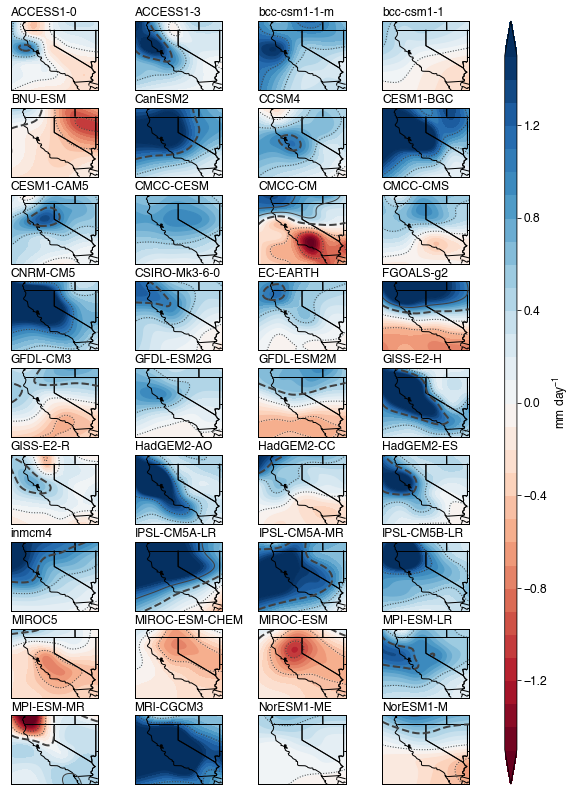

In [19]:
fontsize=12
fig = mp.figure(figsize=(8.5,11))

ax_top_bottom = []

#contour_levels = numpy.hstack((numpy.arange(-0.5,0,0.05), numpy.arange(0,1.8,0.1)))
contour_levels = numpy.arange(-1.5,1.6,0.1)
for i in range(36):
    
    #ax = mp.subplot2grid((5,6),(2,2*i),colspan=2,rowspan=2)

    ax = fig.add_subplot(9,4,i+1)
    
    if (i+1)==4:
        ax_top_bottom.append(ax)
    if (i+1)==36:
        ax_top_bottom.append(ax)
    
    ax.text(s=model_names[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)

    map = basemap.Basemap(projection='cea',llcrnrlat=dict_pr['lats'].min(),\
                          urcrnrlat=dict_pr['lats'].max(),\
                          llcrnrlon=dict_pr['lons'].min(),\
                          urcrnrlon=dict_pr['lons'].max(),\
                          resolution='l')

    map.drawcoastlines(linewidth=1, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
    map.drawmapboundary(linewidth=1, color='0')
    map.drawstates(linewidth=1, color='0')
    map.drawcountries(linewidth=1, color='0')

    lons,lats = numpy.meshgrid(dict_pr['lons'], dict_pr['lats'])
    field = dict_pr['fields_eoc_mods'][i] - dict_pr['fields_hist_mods'][i]
    xi,yi = map(lons, lats)
    
    xi_smooth = scipy.ndimage.zoom(xi,10)
    yi_smooth = scipy.ndimage.zoom(yi,10)
    field_smooth = scipy.ndimage.zoom(field,10)

    pr_map = map.contourf(xi_smooth, \
                          yi_smooth, \
                          field_smooth, \
                          levels=contour_levels, \
                          extend='both', \
                          cmap='RdBu')
    
    pr_map_contourlines = map.contour(xi_smooth, \
                           yi_smooth, \
                           field_smooth, \
                           levels=[-1,-0.5,0,0.5,1.], \
                           linestyles=[':']*2+['--']+['-']*2, \
                           linewidths=[1]*2+[2]+[1]*2, \
                           colors=['0.25']*5)

    for c in pr_map.collections:
        c.set_edgecolor("face")

fig.tight_layout(w_pad=-7)

bbox_top = ax_top_bottom[0].get_position()
bbox_bottom = ax_top_bottom[1].get_position()
cbar_axes = fig.add_axes([bbox_top.x1-0.05, bbox_bottom.y0, 0.02, bbox_top.y1-bbox_bottom.y0])#, transform=ax_top.transAxes)
cbar = mp.colorbar(pr_map, orientation='vertical', cax=cbar_axes)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{-1}$', fontsize=fontsize)
#cbar.set_ticks(numpy.arange(-0.5,1.51,0.25))
cbar.solids.set_edgecolor("face")

fig.savefig('cmip5_anomalies_djf_2070-2100_1980-2010_600dpi.png', dpi=600, transparent=True, bbox_inches='tight')